# Sentiment Analysis of Canadian Banks' reviews: Insights for Informed Decision-Making

This Jupyter notebook is dedicated to the comprehensive analysis of customer sentiments towards the top five Canadian banks. The primary goal is to uncover and present key insights that potential customers and stakeholders can use to make informed decisions regarding their banking choices. The notebook includes detailed steps for data cleaning to ensure the accuracy and reliability of the analysis. Subsequent sections perform rigorous sentiment analysis, leveraging natural language processing techniques to interpret and quantify customer reviews and feedback. The final outputs are visualized through graphs and charts, providing a clear depiction of sentiment trends and patterns across different banks and services, empowering users with actionable financial insights.



In [2]:
import pandas as pd

# Load the Excel file
df = pd.read_excel('./data/Merged_CSV_excel_file.xlsx', engine='openpyxl')

# Display the first few rows of the DataFrame
print(df.head())


             Submission date           AppID AppName Country Review Language  \
0  2016-09-25T16:46:19+00:00  com.bmo.mobile     NaN      us              en   
1  2016-09-25T16:04:36+00:00  com.bmo.mobile     NaN      us             NaN   
2  2016-09-22T03:28:06+00:00  com.bmo.mobile     NaN      us              en   
3  2016-09-21T22:18:00+00:00  com.bmo.mobile     NaN      us              en   
4  2016-09-21T19:49:46+00:00  com.bmo.mobile     NaN      us              en   

  Version         Author  Rating                          Title  \
0     NaN  A Google user       2   Lacklustre and Underwhelming   
1     NaN  A Google user       5                            Bmo   
2     NaN  A Google user       5                            NaN   
3     NaN  A Google user       1            Used to be great...   
4     NaN  A Google user       4  Needs SMS & Cheque depositing   

                                              Review  ...  Semantic Sentiment  \
0  Come on BMO.. get mobile deposit

In [3]:
rows_to_delete = ['Country', 'Version', 'Author', 'Translated title', 'Translated review', 'User', 'Tags', 'Categories', 'Updated', 'Semantic Tags', 'Semantic Categories', 'Semantic Sentiment', 'Notes', 'Likes', 'Dislikes', 'Link', 'Permalink', 'AF Link', 'Device Name', 'VersionCode', 'OS']

df.drop(rows_to_delete, axis=1, inplace=True)

print(df.head())



             Submission date           AppID AppName Review Language  Rating  \
0  2016-09-25T16:46:19+00:00  com.bmo.mobile     NaN              en       2   
1  2016-09-25T16:04:36+00:00  com.bmo.mobile     NaN             NaN       5   
2  2016-09-22T03:28:06+00:00  com.bmo.mobile     NaN              en       5   
3  2016-09-21T22:18:00+00:00  com.bmo.mobile     NaN              en       1   
4  2016-09-21T19:49:46+00:00  com.bmo.mobile     NaN              en       4   

                           Title  \
0   Lacklustre and Underwhelming   
1                            Bmo   
2                            NaN   
3            Used to be great...   
4  Needs SMS & Cheque depositing   

                                              Review Reply Date Reply Delta  \
0  Come on BMO.. get mobile deposit already. It's...        NaN         NaN   
1                                        Awesomeness        NaN         NaN   
2                     Compact and light on resources        NaN  

In [4]:
# Update the 'Submission date' column to contain only the date part (before 'T')
df['Submission date'] = df['Submission date'].str.split('T').str[0]

display(df)

,Submission date,AppID,AppName,Review Language,Rating,Title,Review,Reply Date,Reply Delta,Developer Reply
0,2016-09-25,com.bmo.mobile,NaN,en,2,Lacklustre and Underwhelming,Come on BMO.. get mobile deposit already. It's...,NaN,NaN,NaN
1,2016-09-25,com.bmo.mobile,NaN,NaN,5,Bmo,Awesomeness,NaN,NaN,NaN
2,2016-09-22,com.bmo.mobile,NaN,en,5,NaN,Compact and light on resources,NaN,NaN,NaN
3,2016-09-21,com.bmo.mobile,NaN,en,1,Used to be great...,This app used to be amazing but once it did th...,NaN,NaN,NaN
4,2016-09-21,com.bmo.mobile,NaN,en,4,Needs SMS & Cheque depositing,"It's a great app, especially now that it doesn...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
114681,2016-09-24,358790776,TD Canada,en,1,Doesn't work,"It kept showing me system error, can't log in ...",NaN,NaN,NaN
114682,2016-09-24,358790776,TD Canada,en,1,Doesn't work,System error every time I try to log in. Can't...,NaN,NaN,NaN
114683,2016-09-24,358790776,TD Canada,en,5,Great,App is good. Until TD touch comes out you can ...,NaN,NaN,NaN
114684,2016-09-24,358790776,TD Canada,en,1,Crashes with e transfers,Brutal trying to do an etransfer to collect mo...,NaN,NaN,NaN


In [5]:
df_removed_columns_and_formatted_date = df.copy()
display(df_removed_columns_and_formatted_date)

print(df['AppID'][4] == "com.bmo.mobile")

,Submission date,AppID,AppName,Review Language,Rating,Title,Review,Reply Date,Reply Delta,Developer Reply
0,2016-09-25,com.bmo.mobile,NaN,en,2,Lacklustre and Underwhelming,Come on BMO.. get mobile deposit already. It's...,NaN,NaN,NaN
1,2016-09-25,com.bmo.mobile,NaN,NaN,5,Bmo,Awesomeness,NaN,NaN,NaN
2,2016-09-22,com.bmo.mobile,NaN,en,5,NaN,Compact and light on resources,NaN,NaN,NaN
3,2016-09-21,com.bmo.mobile,NaN,en,1,Used to be great...,This app used to be amazing but once it did th...,NaN,NaN,NaN
4,2016-09-21,com.bmo.mobile,NaN,en,4,Needs SMS & Cheque depositing,"It's a great app, especially now that it doesn...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
114681,2016-09-24,358790776,TD Canada,en,1,Doesn't work,"It kept showing me system error, can't log in ...",NaN,NaN,NaN
114682,2016-09-24,358790776,TD Canada,en,1,Doesn't work,System error every time I try to log in. Can't...,NaN,NaN,NaN
114683,2016-09-24,358790776,TD Canada,en,5,Great,App is good. Until TD touch comes out you can ...,NaN,NaN,NaN
114684,2016-09-24,358790776,TD Canada,en,1,Crashes with e transfers,Brutal trying to do an etransfer to collect mo...,NaN,NaN,NaN


True


In [6]:
# Function to map AppID to AppName
def update_app_name(app_id):
    if app_id == "com.bmo.mobile":
        return "bmo_GooglePlay"
    elif app_id == "com.cibc.android.mobi":
        return "cibc_GooglePlay"
    elif app_id == "ca.bnc.android":
        return "nbc_GooglePlay"
    elif app_id == "com.rbc.mobile.android":
        return "rbc_GooglePlay"
    elif app_id == 407597290:
        return "rbc_AppStore"
    elif app_id == "com.scotiabank.banking":
        return "scotia_GooglePlay"
    elif app_id == "com.td":
        return "td_GooglePlay"
    elif app_id == 358790776:
        return "td_AppStore"
    else:
        return df['AppName']  # Retain existing AppName if no match

# Apply the function to the 'AppID' column and update the 'AppName' column
df['AppName'] = df['AppID'].apply(update_app_name)

display(df)

,Submission date,AppID,AppName,Review Language,Rating,Title,Review,Reply Date,Reply Delta,Developer Reply
0,2016-09-25,com.bmo.mobile,bmo_GooglePlay,en,2,Lacklustre and Underwhelming,Come on BMO.. get mobile deposit already. It's...,NaN,NaN,NaN
1,2016-09-25,com.bmo.mobile,bmo_GooglePlay,NaN,5,Bmo,Awesomeness,NaN,NaN,NaN
2,2016-09-22,com.bmo.mobile,bmo_GooglePlay,en,5,NaN,Compact and light on resources,NaN,NaN,NaN
3,2016-09-21,com.bmo.mobile,bmo_GooglePlay,en,1,Used to be great...,This app used to be amazing but once it did th...,NaN,NaN,NaN
4,2016-09-21,com.bmo.mobile,bmo_GooglePlay,en,4,Needs SMS & Cheque depositing,"It's a great app, especially now that it doesn...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
114681,2016-09-24,358790776,td_AppStore,en,1,Doesn't work,"It kept showing me system error, can't log in ...",NaN,NaN,NaN
114682,2016-09-24,358790776,td_AppStore,en,1,Doesn't work,System error every time I try to log in. Can't...,NaN,NaN,NaN
114683,2016-09-24,358790776,td_AppStore,en,5,Great,App is good. Until TD touch comes out you can ...,NaN,NaN,NaN
114684,2016-09-24,358790776,td_AppStore,en,1,Crashes with e transfers,Brutal trying to do an etransfer to collect mo...,NaN,NaN,NaN


In [8]:
set_up_AppID_and_AppName = df.copy()
display(set_up_AppID_and_AppName)

# df.to_excel('./data/cleaned_xl_file.xlsx', index=False)


,Submission date,AppID,AppName,Review Language,Rating,Title,Review,Reply Date,Reply Delta,Developer Reply
0,2016-09-25,com.bmo.mobile,bmo_GooglePlay,en,2,Lacklustre and Underwhelming,Come on BMO.. get mobile deposit already. It's...,NaN,NaN,NaN
1,2016-09-25,com.bmo.mobile,bmo_GooglePlay,NaN,5,Bmo,Awesomeness,NaN,NaN,NaN
2,2016-09-22,com.bmo.mobile,bmo_GooglePlay,en,5,NaN,Compact and light on resources,NaN,NaN,NaN
3,2016-09-21,com.bmo.mobile,bmo_GooglePlay,en,1,Used to be great...,This app used to be amazing but once it did th...,NaN,NaN,NaN
4,2016-09-21,com.bmo.mobile,bmo_GooglePlay,en,4,Needs SMS & Cheque depositing,"It's a great app, especially now that it doesn...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
114681,2016-09-24,358790776,td_AppStore,en,1,Doesn't work,"It kept showing me system error, can't log in ...",NaN,NaN,NaN
114682,2016-09-24,358790776,td_AppStore,en,1,Doesn't work,System error every time I try to log in. Can't...,NaN,NaN,NaN
114683,2016-09-24,358790776,td_AppStore,en,5,Great,App is good. Until TD touch comes out you can ...,NaN,NaN,NaN
114684,2016-09-24,358790776,td_AppStore,en,1,Crashes with e transfers,Brutal trying to do an etransfer to collect mo...,NaN,NaN,NaN


# Processing cleaned data

In [1]:
import pandas as pd


df = pd.read_excel('./data/cleaned_xl_file.xlsx', engine='openpyxl')

# Display the first few rows of the DataFrame
print(df.head())


  Submission date           AppID         AppName Review Language  Rating  \
0      2016-09-25  com.bmo.mobile  bmo_GooglePlay              en       2   
1      2016-09-25  com.bmo.mobile  bmo_GooglePlay             NaN       5   
2      2016-09-22  com.bmo.mobile  bmo_GooglePlay              en       5   
3      2016-09-21  com.bmo.mobile  bmo_GooglePlay              en       1   
4      2016-09-21  com.bmo.mobile  bmo_GooglePlay              en       4   

                           Title  \
0   Lacklustre and Underwhelming   
1                            Bmo   
2                            NaN   
3            Used to be great...   
4  Needs SMS & Cheque depositing   

                                              Review Reply Date Reply Delta  \
0  Come on BMO.. get mobile deposit already. It's...        NaN         NaN   
1                                        Awesomeness        NaN         NaN   
2                     Compact and light on resources        NaN         NaN   
3  T

Review Language
en    99923
fr     8038
Name: count, dtype: int64


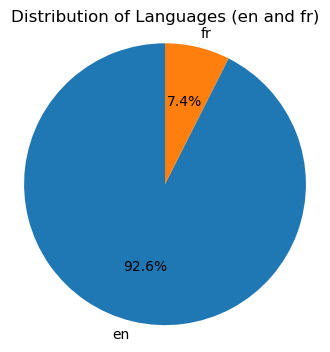

,Submission date,AppID,AppName,Review Language,Rating,Title,Review,Reply Date,Reply Delta,Developer Reply
0,2016-09-25,com.bmo.mobile,bmo_GooglePlay,en,2,Lacklustre and Underwhelming,Come on BMO.. get mobile deposit already. It's...,NaN,NaN,NaN
2,2016-09-22,com.bmo.mobile,bmo_GooglePlay,en,5,NaN,Compact and light on resources,NaN,NaN,NaN
3,2016-09-21,com.bmo.mobile,bmo_GooglePlay,en,1,Used to be great...,This app used to be amazing but once it did th...,NaN,NaN,NaN
4,2016-09-21,com.bmo.mobile,bmo_GooglePlay,en,4,Needs SMS & Cheque depositing,"It's a great app, especially now that it doesn...",NaN,NaN,NaN
5,2016-09-21,com.bmo.mobile,bmo_GooglePlay,en,3,NaN,Having problems opening this app now why?,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
114681,2016-09-24,358790776,td_AppStore,en,1,Doesn't work,"It kept showing me system error, can't log in ...",NaN,NaN,NaN
114682,2016-09-24,358790776,td_AppStore,en,1,Doesn't work,System error every time I try to log in. Can't...,NaN,NaN,NaN
114683,2016-09-24,358790776,td_AppStore,en,5,Great,App is good. Until TD touch comes out you can ...,NaN,NaN,NaN
114684,2016-09-24,358790776,td_AppStore,en,1,Crashes with e transfers,Brutal trying to do an etransfer to collect mo...,NaN,NaN,NaN


In [29]:
import matplotlib.pyplot as plt


# Remove all rows where the 'language' column is not 'en' or 'fr'
# df_filtered = df[df['Review Language'].isin(['en', 'fr'])]
df_filtered = df[(df['Review Language'].isin(['en', 'fr'])) & (df['Review Language'].notna()) & (df['Review Language'].str.strip() != '')]

# Create a pie chart categorized by language
language_counts = df_filtered['Review Language'].value_counts()
print(language_counts)

# Plot pie chart
plt.figure(figsize=(4, 4))
plt.pie(language_counts, labels=language_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Languages (en and fr)')
plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.
plt.show()
display(df_filtered)

# df_filtered.to_excel('./data/cleaned_xl_file_en_fr.xlsx', index=False)


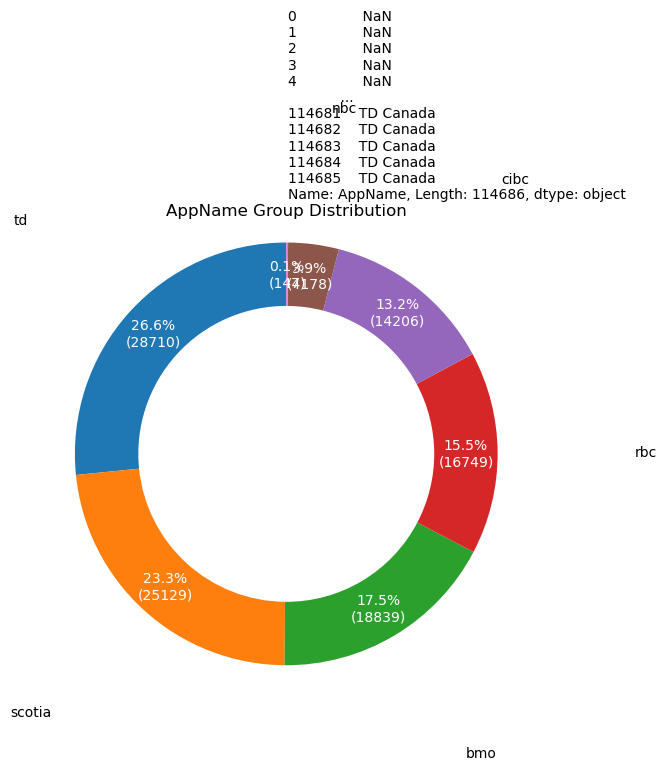

In [31]:

# Group by the substring before the underscore in 'AppName'
analyze_df = df_filtered.copy()
analyze_df['AppGroup'] = analyze_df['AppName'].str.split('_').str[0]

# Get the count for each group
group_counts = analyze_df['AppGroup'].value_counts()

# Function to show both percentage and count
def func(pct, allvalues):
    absolute = int(pct/100.*sum(allvalues))
    return f"{pct:.1f}%\n({absolute:d})"

# Plot donut chart with category labels, percentages, and counts
plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    group_counts, 
    labels=group_counts.index,  # Category labels only
    autopct=lambda pct: func(pct, group_counts),  # Show percentage and count
    startangle=90, 
    wedgeprops={'width': 0.3},  # Makes it a donut chart
    pctdistance=0.85,  # Position the percentages closer to the center
    textprops=dict(color="black"),  # Set text color for the category labels
    labeldistance=1.65  # Set distance for the category labels outside the chart
)

# Customize percentage and count text appearance inside slices
for autotext in autotexts:
    autotext.set_fontsize(10)  # Set font size of percentages and counts
    autotext.set_color('white')  # Set color of percentage text

# Set title for the chart
plt.title('AppName Group Distribution')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Display the chart
plt.show()

In [33]:
row_count = df_filtered.shape[0]

print(row_count)

107961


In [34]:
display(df_filtered)

,Submission date,AppID,AppName,Review Language,Rating,Title,Review,Reply Date,Reply Delta,Developer Reply
0,2016-09-25,com.bmo.mobile,bmo_GooglePlay,en,2,Lacklustre and Underwhelming,Come on BMO.. get mobile deposit already. It's...,NaN,NaN,NaN
2,2016-09-22,com.bmo.mobile,bmo_GooglePlay,en,5,NaN,Compact and light on resources,NaN,NaN,NaN
3,2016-09-21,com.bmo.mobile,bmo_GooglePlay,en,1,Used to be great...,This app used to be amazing but once it did th...,NaN,NaN,NaN
4,2016-09-21,com.bmo.mobile,bmo_GooglePlay,en,4,Needs SMS & Cheque depositing,"It's a great app, especially now that it doesn...",NaN,NaN,NaN
5,2016-09-21,com.bmo.mobile,bmo_GooglePlay,en,3,NaN,Having problems opening this app now why?,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
114681,2016-09-24,358790776,td_AppStore,en,1,Doesn't work,"It kept showing me system error, can't log in ...",NaN,NaN,NaN
114682,2016-09-24,358790776,td_AppStore,en,1,Doesn't work,System error every time I try to log in. Can't...,NaN,NaN,NaN
114683,2016-09-24,358790776,td_AppStore,en,5,Great,App is good. Until TD touch comes out you can ...,NaN,NaN,NaN
114684,2016-09-24,358790776,td_AppStore,en,1,Crashes with e transfers,Brutal trying to do an etransfer to collect mo...,NaN,NaN,NaN


In [1]:
# Creating batches from entire dataset
import numpy as np

# Define batch size
batch_size = 20000

# Split DataFrame into batches of 20,000 rows
batches = np.array_split(df_filtered, len(df_filtered) // batch_size + 1)

NameError: name 'df_filtered' is not defined

In [45]:

subbatch = batches[0].head(100)
count_fr = subbatch[subbatch['Review Language'] == 'fr'].shape[0]

print(count_fr)

9


In [42]:
import pandas as pd
from transformers import MarianMTModel, MarianTokenizer
import sentencepiece as spm

# Load the pre-trained MarianMT model for translating French to English
model_name = 'Helsinki-NLP/opus-mt-fr-en'
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

# Function to translate French reviews to English
def translate_to_english(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    # Generate the translated tokens
    translated_tokens = model.generate(**inputs)
    # Decode the tokens to get the translated string
    translated_text = tokenizer.decode(translated_tokens[0], skip_special_tokens=True)
    return translated_text

# Apply translation only where 'Review Language' is 'fr'
batches[0]['Review'] = batches[0].apply(
    lambda row: translate_to_english(row['Review']) if row['Review Language'] == 'fr' else row['Review'], axis=1
)

display(batches[0])

ImportError: 
MarianTokenizer requires the SentencePiece library but it was not found in your environment. Checkout the instructions on the
installation page of its repo: https://github.com/google/sentencepiece#installation and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.


#Further steps

In [21]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

# Load the pre-trained RoBERTa model for sentiment analysis
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create a sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Function to analyze sentiment using the RoBERTa model
def analyze_sentiment(review_text):
    result = sentiment_pipeline(review_text)[0]                                                                                                             
    label = result['label']
    # Map the RoBERTa model's output to 'positive', 'negative', or 'neutral'
    if label == 'LABEL_2':  # Positive sentiment
        return 'positive'
    elif label == 'LABEL_0':  # Negative sentiment
        return 'negative'
    else:
        return 'neutral'

# Assuming df is your existing dataframe with a 'Review' column
# Apply the sentiment analysis to the 'Review' column and create a new column 'Review sentiment'
df_filtered['Review sentiment'] = df_filtered['Review'].astype(str).apply(analyze_sentiment)

display(df_filtered)


C:\Users\Bhautik\miniconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


KeyboardInterrupt: 

In [10]:
# Converting all reviews to english

In [11]:
from googletrans import Translator

# Initialize the Google Translator
translator = Translator()

# Translate the text where 'Review Language' is 'fr'
df_filtered.loc[df['Review Language'] == 'fr', 'Review'] = df_filtered.loc[df['Review Language'] == 'fr', 'Review'].apply(lambda x: translator.translate(x, src='fr', dest='en').text)

display(df_filtered)

AttributeError: 'Translator' object has no attribute 'raise_Exception'